# GAMs: feature engeneering
This notebook contains our first tries with implementing GAMs on our data.
It also contains models with different feature sets and their comparison, leading to our final model architecture decision.

## Load Data and Merge Bicycle and Weather Datasets

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
from pygam import LinearGAM, f, s, te 
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# data load 
mstl_data = pd.read_csv("../data/mstl_results_clean.csv", low_memory=False)

In [ ]:
# For now, only use data for Freiburg
mstl_data = mstl_data[mstl_data["city"] == "Stadt Freiburg"].copy()

In [ ]:
# Overview of mstl_data columns
mstl_data.columns.tolist()

['timestamp',
 'city',
 'counter_site',
 'longitude',
 'latitude',
 'count',
 'count_capped',
 'log_count',
 'trend',
 'seasonal_24',
 'seasonal_168',
 'seasonal_8766',
 'residual']

In [ ]:
# Extract required columns for GAMs
residual_data = mstl_data[['timestamp',
 'city',
 'counter_site',
 #'longitude',
 #'latitude',
 #'count',
 #'count_capped',
 #'log_count',
 'seasonal_8766',
 'residual']].copy()
# Filter out rows where column names appear instead of values
residual_data = residual_data[residual_data['timestamp']!='timestamp']

In [ ]:
residual_data['id'] = residual_data.groupby(['city', 'counter_site']).ngroup()
# use type category to save memory
residual_data["city"] = residual_data["city"].astype("category")
residual_data["counter_site"] = residual_data["counter_site"].astype("category")
residual_data["id"] = residual_data.groupby(["city", "counter_site"]).ngroup().astype("int32")

C:\Users\kraus\AppData\Local\Temp\ipykernel_4016\1898149343.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  residual_data["id"] = residual_data.groupby(["city", "counter_site"]).ngroup().astype("int32")


In [ ]:
len(list(set(residual_data['id'].to_list())))

4

In [ ]:
residual_data['year_plus_res'] = residual_data['residual'].astype(float).values + residual_data['seasonal_8766'].astype(float).values
# drop residual and seasonal_8766 columns to save memory
residual_data = residual_data.drop(columns=['residual', 'seasonal_8766'])
residual_data.head(2)

,timestamp,city,counter_site,id,year_plus_res
877517,2012-12-31 23:00:00+00:00,Stadt Freiburg,Wiwilibrücke,3,-0.587504
877518,2013-01-01 00:00:00+00:00,Stadt Freiburg,Wiwilibrücke,3,0.405990


In [ ]:
# load weather data 
weather_data = pd.read_csv("../data/weather_per_city.csv", low_memory=False)
print(weather_data.head(2))
print(weather_data.isna().sum())

                        date  temperature_2m  apparent_temperature  rain  \
0  2012-12-30 23:00:00+00:00          5.8285              1.619927   0.0   
1  2012-12-31 00:00:00+00:00          5.8285              1.688656   0.0   

   snowfall  forecast_temperature_2m  forecast_apparent_temperature  \
0       0.0                      NaN                            NaN   
1       0.0                      NaN                            NaN   

   forecast_rain  forecast_snowfall                        city  
0            NaN                NaN  Landeshauptstadt Stuttgart  
1            NaN                NaN  Landeshauptstadt Stuttgart  
date                                   0
temperature_2m                         0
apparent_temperature                   0
rain                                   0
snowfall                               0
forecast_temperature_2m          1586134
forecast_apparent_temperature    1586134
forecast_rain                    1586156
forecast_snowfall              

In [ ]:
# For now, keep only weather data for Freiburg
weather_data = weather_data[weather_data["city"] == "Stadt Freiburg"].copy()

In [ ]:
print(weather_data.columns.tolist())

['date', 'temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_apparent_temperature', 'forecast_rain', 'forecast_snowfall', 'city']


In [ ]:
# Save normalization parameters
norm_params = {}
for col in ['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'forecast_temperature_2m', 'forecast_apparent_temperature', 'forecast_rain', 'forecast_snowfall']:
    norm_params[col] = {
        'mean': weather_data[col].mean(),
        'std': weather_data[col].std()
    }
    weather_data[col] = (weather_data[col] - norm_params[col]['mean']) / norm_params[col]['std']
    print(f"Normalized {col}: mean={norm_params[col]['mean']}, std={norm_params[col]['std']}")


Normalized temperature_2m: mean=11.423920678630337, std=7.904912754911367
Normalized apparent_temperature: mean=9.683018682486475, std=9.444009266223597
Normalized rain: mean=0.11443804593007713, std=0.4224145076905251
Normalized snowfall: mean=0.005500493125616371, std=0.047723741943904295
Normalized forecast_temperature_2m: mean=12.746343465271057, std=7.680902125421976
Normalized forecast_apparent_temperature: mean=11.237384410506667, std=9.057690768257725
Normalized forecast_rain: mean=0.09403665343271053, std=0.5816270771480397
Normalized forecast_snowfall: mean=0.0022129250180853628, std=0.030905619948427353


In [ ]:
# merge with weather data by city and date (in weather data) and timestamp (in residual data)
merged_data = pd.merge(residual_data, weather_data, left_on=['city', residual_data['timestamp']], right_on=['city', weather_data['date']], how='left')

print(merged_data.shape)
merged_data.isna().sum()

(305346, 15)


timestamp                             0
key_1                                 0
city                                  0
counter_site                          0
id                                    0
year_plus_res                         0
date                                778
temperature_2m                      778
apparent_temperature                778
rain                                778
snowfall                            778
forecast_temperature_2m          189285
forecast_apparent_temperature    189285
forecast_rain                    189288
forecast_snowfall                189288
dtype: int64

In [ ]:
print(residual_data.shape)
print(merged_data.shape)

(305346, 5)
(305346, 15)


In [ ]:
# Reference timestamp (UTC)
ref = pd.Timestamp(min(residual_data['timestamp'].tolist())) 
print(ref)

# 1) Convert column vectorized to datetime (once)
#t_0 = pd.to_datetime(merged_data['timestamp'], utc=True, errors='coerce') #could be wrong with time shift
t_0 = pd.to_datetime(merged_data['timestamp'], errors='coerce').dt.tz_convert('Europe/Berlin')

# 2) Calculate difference in hours (vectorized)
merged_data['timestamp_number'] = (t_0 - ref).dt.total_seconds() / 3600.0
merged_data['weekday'] = t_0.dt.dayofweek.astype(float).values            # 0–6
merged_data['hour'] = t_0.dt.hour.astype(float).values                    # 0–23

# => timestamp_number is now the number of hours since reference timestamp

2012-12-31 23:00:00+00:00


In [ ]:
# Add lag features
lag_features = ['temperature_2m', 'rain', 'snowfall']
lag_periods = [1, 3, 6, 10]

for feature in lag_features:
    for lag in lag_periods:
        merged_data[f'{feature}_lag{lag}'] = merged_data.groupby('id')[feature].shift(lag)

# Drop NaN values after creating lag features
merged_data = merged_data.dropna()

print(f"Shape after lag features: {merged_data.shape}")
print(f"New columns: {[col for col in merged_data.columns if 'lag' in col]}")

Shape nach Lag-Features: (116058, 30)
Neue Spalten: ['temperature_2m_lag1', 'temperature_2m_lag3', 'temperature_2m_lag6', 'temperature_2m_lag10', 'rain_lag1', 'rain_lag3', 'rain_lag6', 'rain_lag10', 'snowfall_lag1', 'snowfall_lag3', 'snowfall_lag6', 'snowfall_lag10']


## GAMs with observed weather data

In [ ]:
# Print IDs
print(merged_data['id'].unique())

[3 2 1]


In [ ]:
weather_features = ['temperature_2m', 'rain', 'snowfall']
lag_cols = [f'{feat}_lag{lag}' for feat in weather_features for lag in lag_periods]

y = merged_data['year_plus_res'] #.astype(float).values
X = merged_data[['timestamp_number', 'id'] + weather_features + ['weekday', 'hour'] + lag_cols].astype(float).values
# drop rows with NaN values in X or y
mask = ~np.isnan(y) & ~np.isnan(X).any(axis=1)
y = y[mask]
X = X[mask]

In [ ]:
# Create a column with 1/0 indicator for each ID
num_ids = merged_data['id'].nunique()
id_indicators = np.zeros((X.shape[0], num_ids))
for i in range(num_ids):
    id_indicators[:, i] = (X[:, 1] == i+1).astype(float)
# Concatenate id_indicators to X
X = np.hstack((X, id_indicators))

print(X[40, :])

[ 7.21140000e+04  3.00000000e+00  2.37330807e-01 -2.70914099e-01
 -1.15256954e-01  2.00000000e+00  1.80000000e+01  2.68956709e-01
  3.32208514e-01  9.81768358e-02 -8.94876502e-01 -2.70914099e-01
 -2.70914099e-01 -2.70914099e-01 -2.70914099e-01 -1.15256954e-01
 -1.15256954e-01 -1.15256954e-01 -1.15256954e-01  0.00000000e+00
  0.00000000e+00  1.00000000e+00]


In [ ]:
print(X[10000, :])
print(X[100000, :])

[ 8.20740000e+04  3.00000000e+00  1.09755535e+00 -2.70914099e-01
 -1.15256954e-01  4.00000000e+00  1.90000000e+01  1.12285608e+00
  8.76174037e-01  9.20450301e-01  7.05394164e-01 -2.70914099e-01
 -2.70914099e-01  4.39288781e-01 -3.41798060e-02 -1.15256954e-01
 -1.15256954e-01 -1.15256954e-01 -1.15256954e-01  0.00000000e+00
  0.00000000e+00  1.00000000e+00]
[ 8.91340000e+04  1.00000000e+00 -9.77103849e-01 -2.70914099e-01
 -1.15256954e-01  4.00000000e+00  2.20000000e+01 -1.08463192e+00
 -9.83429029e-01 -5.84942658e-01 -7.43072171e-01 -2.70914099e-01
 -2.70914099e-01 -2.70914099e-01 -2.70914099e-01 -1.15256954e-01
 -1.15256954e-01 -1.15256954e-01 -1.15256954e-01  1.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [ ]:
# Split data into train and test to detect overfitting
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sort by timestamp_number
sort_idx = np.argsort(X[:, 0])
X_sorted = X[sort_idx]
y_sorted = y.iloc[sort_idx].values

# Chronological split: 80% training (older data), 20% test (newer data)
split_point = int(0.8 * len(X_sorted))
X_train, X_test = X_sorted[:split_point], X_sorted[split_point:]
y_train, y_test = y_sorted[:split_point], y_sorted[split_point:]

print(f"Training until timestamp: {X_train[:, 0].max()}")
print(f"Test from timestamp: {X_test[:, 0].min()}")

Training bis Zeitpunkt: 103022.0
Test ab Zeitpunkt: 103022.0


In [ ]:
print("Train y mean/std:", y_train.mean(), y_train.std())
print("Test y mean/std:", y_test.mean(), y_test.std())

Train y mean/std: 0.030138529570632483 0.3881561453131963
Test y mean/std: -0.008009306883925277 0.382063907161042


### Feature engeneering
Create different GAMs and evaluate them

In [ ]:
# GAM 1
gam1 = LinearGAM(
    s(0, n_splines=10, lam=1) +          # timestamp_number (drift) -> we don't need this, already removed trend through mstl - model without this feature is even better!
    f(1, lam=50) +                       # id
    s(2, n_splines=6) +                  # temp
    s(3, n_splines=5, lam=2) +           # rain
    s(4, n_splines=5, lam=2) +           # snow
    te(2, 3, n_splines=4, lam=2)         # temp × rain
).fit(X_train, y_train)

In [ ]:
# Print model statistics
print(f"AIC: {gam1.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam1.predict(X_train)
y_test_pred = gam1.predict(X_test)

print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam1.statistics_['edof'])

AIC: 59923.27
Train R2 = Explained Deviance: 0.25936637632300097
Test  R2: -12.224354861135676
Train RMSE: 0.3340474636343334
Test  RMSE: 1.389387092509422
edof: 20.924652847988142


In [ ]:
# GAM3 - without timestamp_number and with gridsearch
gam3 = LinearGAM(
    f(1) +                        # id
    s(2, n_splines=5) +           # temp
    s(3, n_splines=5) +           # rain
    s(4, n_splines=5) +           # snow
    te(2, 3, n_splines=5)         # temp × rain
).gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:06 ETA:   0:01:01
 18% (2 of 11) |####                     | Elapsed Time: 0:00:12 ETA:   0:00:55
 27% (3 of 11) |######                   | Elapsed Time: 0:00:17 ETA:   0:00:47
 36% (4 of 11) |#########                | Elapsed Time: 0:00:23 ETA:   0:00:40
 45% (5 of 11) |###########              | Elapsed Time: 0:00:28 ETA:   0:00:34
 54% (6 of 11) |#############            | Elapsed Time: 0:00:34 ETA:   0:00:28
 63% (7 of 11) |###############          | Elapsed Time: 0:00:39 ETA:   0:00:22
 72% (8 of 11) |##################       | Elapsed Time: 0:00:44 ETA:   0:00:16
 81% (9 of 11) |####################     | Elapsed Time: 0:00:50 ETA:   0:00:11
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:55 ETA:   0:00:05
100% (11 of 11) |########################| Elapsed Time: 0:01:00 Time:  0:01:00


In [ ]:
print(f"AIC: {gam3.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam3.predict(X_train)
y_test_pred = gam3.predict(X_test)
print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam3.statistics_['edof'])

AIC: 63081.61
Train R2 = Explained Deviance: 0.23369941134699812
Test  R2: 0.12728169167825076
Train RMSE: 0.33978644204275027
Test  RMSE: 0.3569217848790293
edof: 18.53492808047978


In [ ]:
# GAM4 - with weekday as non-cyclic variable
gam4 = LinearGAM(
    f(1) +                        # id
    s(2, n_splines=5) +           # temp
    s(3, n_splines=5) +           # rain
    s(4, n_splines=5) +           # snow
    #f(5) +                        # weekday
    te(2, 3, n_splines=5) +       # temp × rain
    te(2, 5, n_splines=5) +       # temp × weekday
    te(3, 5, n_splines=5)         # rain × weekday
).gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:11 ETA:   0:01:50
 18% (2 of 11) |####                     | Elapsed Time: 0:00:22 ETA:   0:01:40
 27% (3 of 11) |######                   | Elapsed Time: 0:00:34 ETA:   0:01:31
 36% (4 of 11) |#########                | Elapsed Time: 0:00:45 ETA:   0:01:19
 45% (5 of 11) |###########              | Elapsed Time: 0:00:57 ETA:   0:01:08
 54% (6 of 11) |#############            | Elapsed Time: 0:01:08 ETA:   0:00:56
 63% (7 of 11) |###############          | Elapsed Time: 0:01:19 ETA:   0:00:45
 72% (8 of 11) |##################       | Elapsed Time: 0:01:30 ETA:   0:00:33
 81% (9 of 11) |####################     | Elapsed Time: 0:01:41 ETA:   0:00:22
 90% (10 of 11) |#####################   | Elapsed Time: 0:01:52 ETA:   0:00:11
100% (11 of 11) |########################| Elapsed Time: 0:02:03 Time:  0:02:03


In [ ]:
print(f"AIC: {gam4.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam4.predict(X_train)
y_test_pred = gam4.predict(X_test)
print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam4.statistics_['edof'])

AIC: 62861.10
Train R2 = Explained Deviance: 0.23593062409871224
Test  R2: 0.10522914383881887
Train RMSE: 0.33929140881532505
Test  RMSE: 0.36140314514325067
edof: 43.6416758515449


In [ ]:
# GAM5 - with weekday and hour as cyclic variables for interactions
gam5 = LinearGAM(
    f(1) +  # id
    s(2, n_splines=4) +           # temp
    s(3, n_splines=4) +           # rain
    s(4, n_splines=4) +           # snow
    te(2, 3, n_splines=4) +       # temp × rain
    te(2, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × weekday (cyclic)
    te(3, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # rain × weekday (cyclic)
    te(2, 6, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × hour (cyclic)
    te(3, 6, n_splines=[4, 5], basis=['ps', 'cp'])    # rain × hour (cyclic)
).gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:16 ETA:   0:02:45
 18% (2 of 11) |####                     | Elapsed Time: 0:00:32 ETA:   0:02:28
 27% (3 of 11) |######                   | Elapsed Time: 0:00:49 ETA:   0:02:11
 36% (4 of 11) |#########                | Elapsed Time: 0:01:06 ETA:   0:01:55
 45% (5 of 11) |###########              | Elapsed Time: 0:01:23 ETA:   0:01:40
 54% (6 of 11) |#############            | Elapsed Time: 0:01:40 ETA:   0:01:23
 63% (7 of 11) |###############          | Elapsed Time: 0:01:57 ETA:   0:01:07
 72% (8 of 11) |##################       | Elapsed Time: 0:02:14 ETA:   0:00:50
 81% (9 of 11) |####################     | Elapsed Time: 0:02:31 ETA:   0:00:33
 90% (10 of 11) |#####################   | Elapsed Time: 0:02:48 ETA:   0:00:16
100% (11 of 11) |########################| Elapsed Time: 0:03:05 Time:  0:03:05


In [ ]:
print(f"AIC: {gam5.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam5.predict(X_train)
y_test_pred = gam5.predict(X_test)
print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam5.statistics_['edof'])

AIC: 61354.18
Train R2 = Explained Deviance: 0.24845332687817834
Test  R2: 0.18288805726696677
Train RMSE: 0.3364995165864728
Test  RMSE: 0.345363782144583
edof: 57.33166389847741


In [ ]:
# GAM5b - with by= and dummies for IDs

formula = (    
    f(1) +  # id
    s(2, n_splines=4) +           # temp
    s(3, n_splines=4) +           # rain
    s(4, n_splines=4) +           # snow
    te(2, 3, n_splines=4) +       # temp × rain
    te(2, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × weekday (cyclic)
    te(3, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # rain × weekday (cyclic)
    te(2, 6, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × hour (cyclic)
    te(3, 6, n_splines=[4, 5], basis=['ps', 'cp'])    # rain × hour (cyclic)
)
# Add ID-specific terms
first_indicator_col = 19 # Adjust to structure of X
for i in range(num_ids):
    formula = formula + s(2, by=first_indicator_col + i, n_splines=4) # temp by ID
    formula = formula + s(3, by=first_indicator_col + i, n_splines=4) # rain by ID

gam5b = LinearGAM(formula).gridsearch(X_train, y_train)

SyntaxError: invalid syntax (105090983.py, line 13)

In [ ]:
print(f"AIC: {gam5b.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam5b.predict(X_train)
y_test_pred = gam5b.predict(X_test)
print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam5b.statistics_['edof'])

In [ ]:
# GAM6 - all lag features
gam6 = LinearGAM(
    f(1) +  # id

    # Current weather data
    s(2, n_splines=4) +           # temp
    s(3, n_splines=4) +           # rain
    s(4, n_splines=4) +           # snow

    # Interactions
    te(2, 3, n_splines=4) +       # temp × rain
    te(2, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × weekday (cyclic)
    te(3, 5, n_splines=[4, 5], basis=['ps', 'cp']) +  # rain × weekday (cyclic)
    te(2, 6, n_splines=[4, 5], basis=['ps', 'cp']) +  # temp × hour (cyclic)
    te(3, 6, n_splines=[4, 5], basis=['ps', 'cp']) +   # rain × hour (cyclic)

    # temp lag features
    s(7, n_splines=4) +           # temp_lag1
    s(8, n_splines=4) +           # temp_lag3
    s(9, n_splines=4) +           # temp_lag6
    s(10, n_splines=4) +          # temp_lag10
    # rain lag features
    s(11, n_splines=4) +          # rain_lag1
    s(12, n_splines=4) +          # rain_lag3
    s(13, n_splines=4) +          # rain_lag6
    s(14, n_splines=4) +          # rain_lag10
    # snowfall lag features
    s(15, n_splines=4) +          # snowfall_lag1
    s(16, n_splines=4) +          # snowfall_lag3
    s(17, n_splines=4) +          # snowfall_lag6
    s(18, n_splines=4)            # snowfall_lag10

).gridsearch(X_train, y_train)

  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:24 ETA:   0:04:03
 18% (2 of 11) |####                     | Elapsed Time: 0:00:47 ETA:   0:03:35
 27% (3 of 11) |######                   | Elapsed Time: 0:01:10 ETA:   0:03:08
 36% (4 of 11) |#########                | Elapsed Time: 0:01:32 ETA:   0:02:41
 45% (5 of 11) |###########              | Elapsed Time: 0:01:53 ETA:   0:02:15
 54% (6 of 11) |#############            | Elapsed Time: 0:02:14 ETA:   0:01:52
 63% (7 of 11) |###############          | Elapsed Time: 0:02:35 ETA:   0:01:28
 72% (8 of 11) |##################       | Elapsed Time: 0:02:56 ETA:   0:01:06
 81% (9 of 11) |####################     | Elapsed Time: 0:03:18 ETA:   0:00:44
 90% (10 of 11) |#####################   | Elapsed Time: 0:03:39 ETA:   0:00:21
100% (11 of 11) |########################| Elapsed Time: 0:04:00 Time:  0:04:00


In [ ]:
print(f"AIC: {gam6.statistics_['AIC']:.2f}")

# Training vs. testing performance
y_train_pred = gam6.predict(X_train)
y_test_pred = gam6.predict(X_test)
print("Train R2 = Explained Deviance:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("Test  RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("edof:", gam6.statistics_['edof'])

AIC: 59045.75


Train R2 = Explained Deviance: 0.26725377623101865
Test  R2: 0.17465915707658342
Train RMSE: 0.3322837439140897
Test  RMSE: 0.3471429260757391
edof: 81.27167325862155


### Visualize Results

In [ ]:
# Adjust this line if you want to visualize a different model
gam = gam5

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     98.2778
Link Function:                     IdentityLink Log Likelihood:                                -29047.8061
Number of Samples:                        92822 AIC:                                            58294.1678
                                                AICc:                                           58294.3825
                                                GCV:                                                0.1098
                                                Scale:                                              0.3311
                                                Pseudo R-Squared:                                   0.2734
Feature Function                  Lam

C:\Users\kraus\AppData\Local\Temp\ipykernel_8424\710967099.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam7.summary()


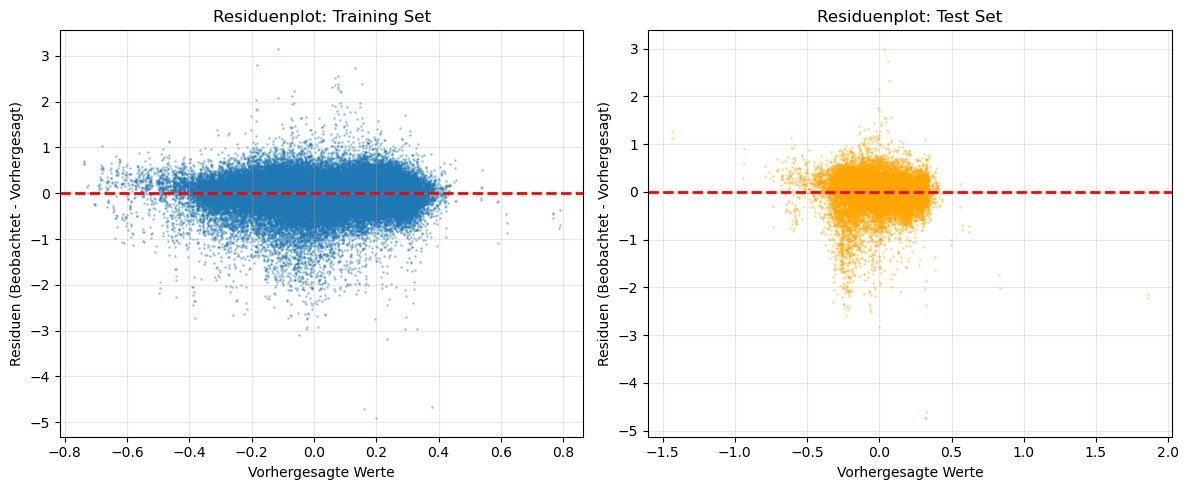

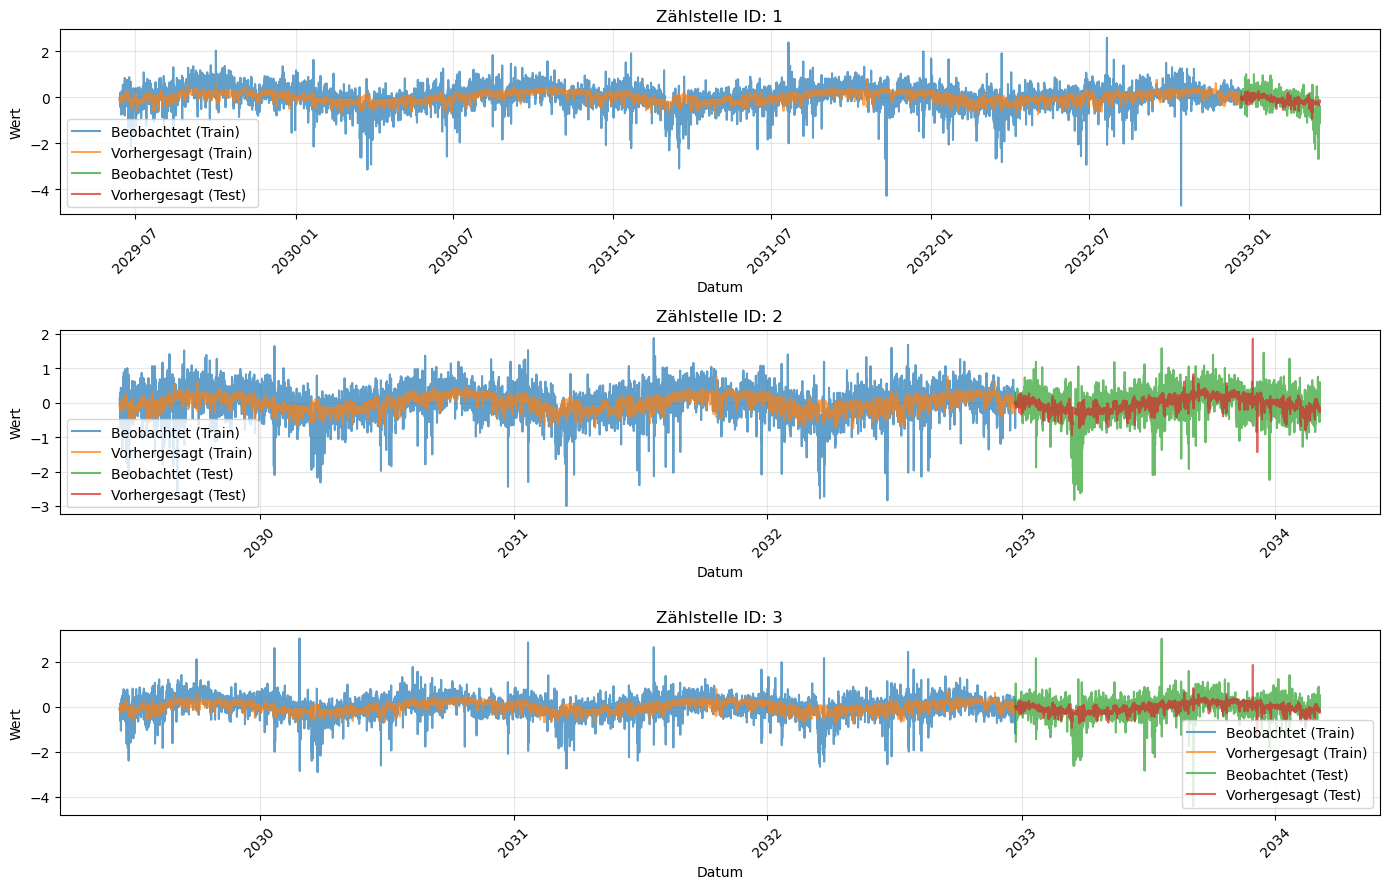

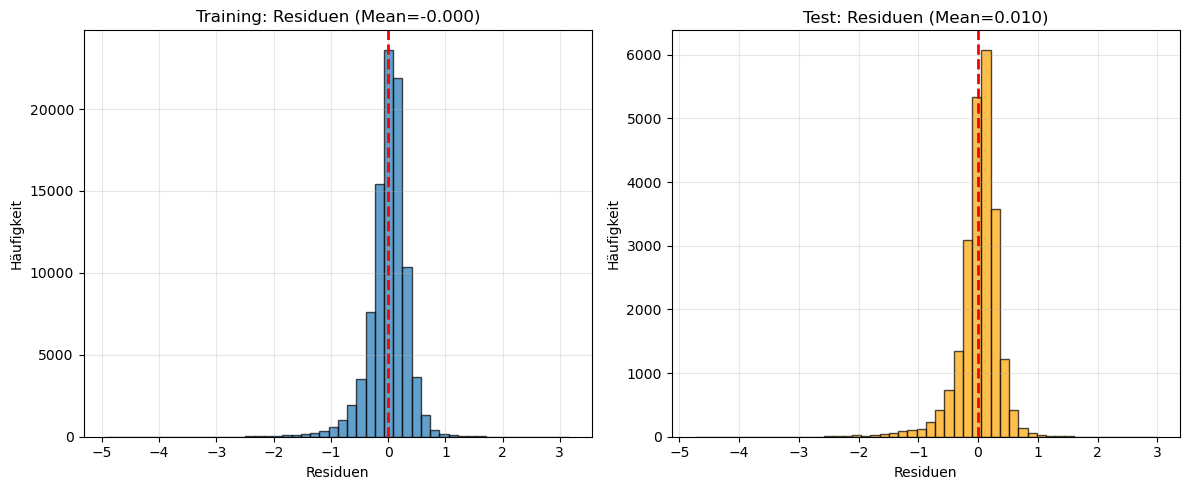

In [ ]:
y_train_pred = gam.predict(X_train)
y_test_pred = gam.predict(X_test)

# 2) Residual plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

axes[0].scatter(y_train_pred, residuals_train, alpha=0.3, s=1)
axes[0].axhline(0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted values')
axes[0].set_ylabel('Residuals (Observed - Predicted)')
axes[0].set_title('Residual plot: Training Set')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test_pred, residuals_test, alpha=0.3, s=1, color='orange')
axes[1].axhline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted values')
axes[1].set_ylabel('Residuals (Observed - Predicted)')
axes[1].set_title('Residual plot: Test Set')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3) Time series plot
# Reference timestamp from data
ref = pd.Timestamp(min(merged_data['timestamp'].tolist()))

# Convert timestamp_number back to actual dates
train_dates = pd.to_datetime([ref + pd.Timedelta(hours=float(ts)) for ts in X_train[:, 0]])
test_dates = pd.to_datetime([ref + pd.Timedelta(hours=float(ts)) for ts in X_test[:, 0]])

# Extract counter IDs from X_train and X_test
train_ids = X_train[:, 1]
test_ids = X_test[:, 1]

# One subplot per counter site
unique_ids = np.unique(np.concatenate([train_ids, test_ids]))
fig, axes = plt.subplots(len(unique_ids), 1, figsize=(14, 3*len(unique_ids)))

for idx, counter_id in enumerate(unique_ids):
    mask_train = train_ids == counter_id
    mask_test = test_ids == counter_id
    
    axes[idx].plot(train_dates[mask_train], y_train[mask_train], label='Observed (Train)', alpha=0.7)
    axes[idx].plot(train_dates[mask_train], y_train_pred[mask_train], label='Predicted (Train)', alpha=0.7)
    axes[idx].plot(test_dates[mask_test], y_test[mask_test], label='Observed (Test)', alpha=0.7)
    axes[idx].plot(test_dates[mask_test], y_test_pred[mask_test], label='Predicted (Test)', alpha=0.7)
    
    axes[idx].set_title(f'Counter site ID: {int(counter_id)}')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Format x-axis for readability
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 4) Histogram of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(residuals_train, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Training: Residuals (Mean={residuals_train.mean():.3f})')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Test: Residuals (Mean={residuals_test.mean():.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

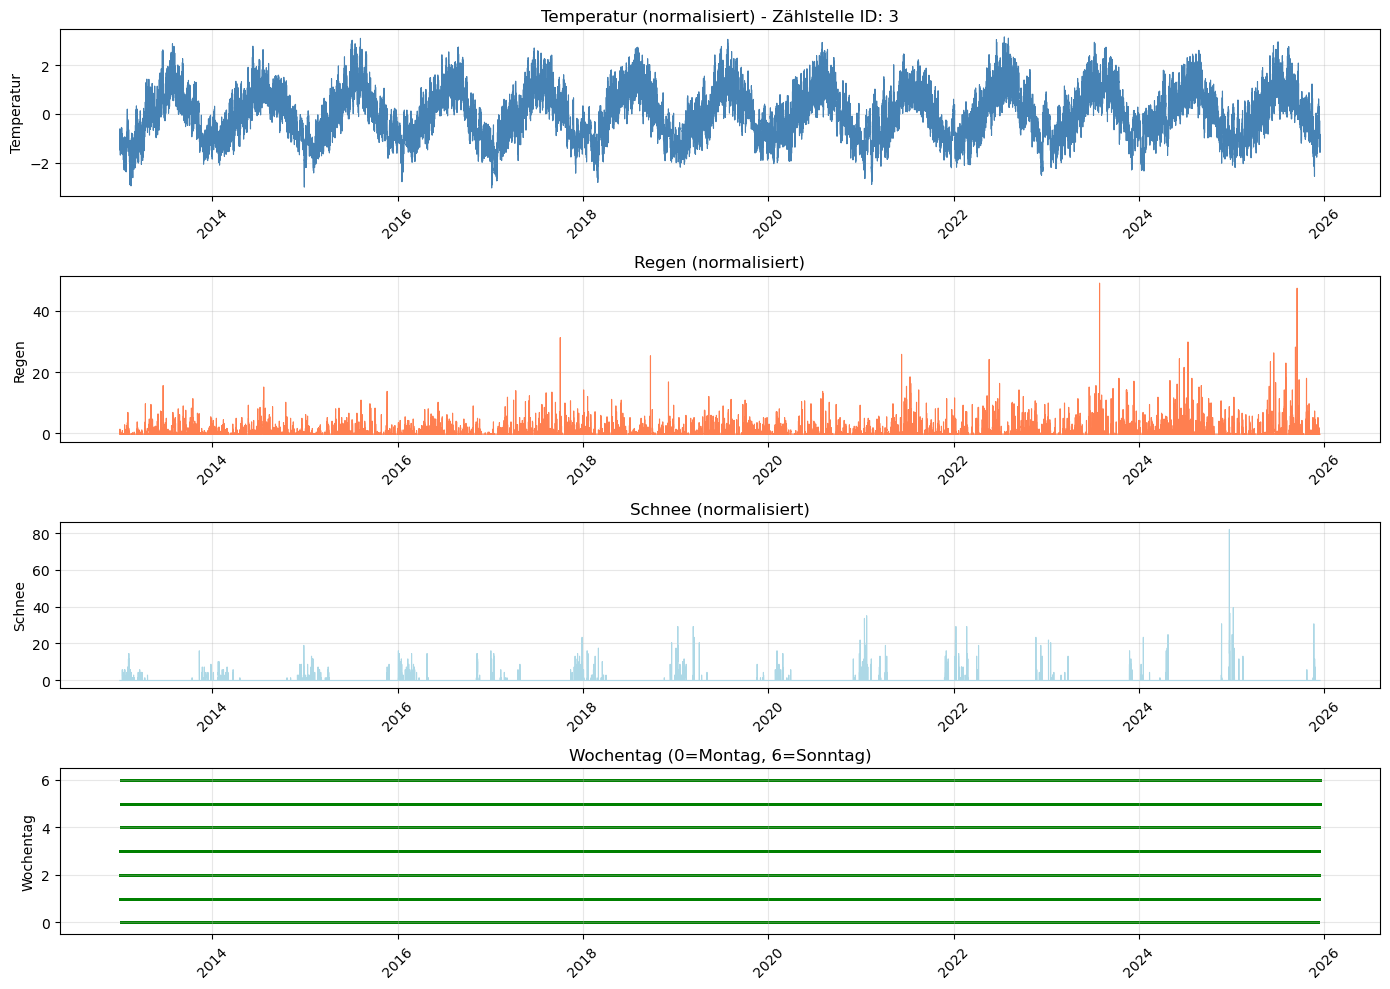

In [ ]:
# Visualize weather data as time series - only last counter site
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Extract only data from the last counter site
all_ids = X[:, 1]
last_id = np.max(all_ids)
mask_last = all_ids == last_id

# Timestamps for last counter site
all_timestamps = X[mask_last, 0]
all_dates = pd.to_datetime([ref + pd.Timedelta(hours=int(ts)) for ts in all_timestamps])

# Column indices in X: [timestamp_number, id, temperature_2m, rain, snowfall, weekday]
# So: 2=temperature, 3=rain, 4=snowfall

# 1) Temperature (normalized)
axes[0].plot(all_dates, X[mask_last, 2], linewidth=0.8, color='steelblue')
axes[0].set_title(f'Temperature (normalized) - Counter site ID: {int(last_id)}')
axes[0].set_ylabel('Temperature')
axes[0].grid(True, alpha=0.3)

# 2) Rain (normalized)
axes[1].plot(all_dates, X[mask_last, 3], linewidth=0.8, color='coral')
axes[1].set_title('Rain (normalized)')
axes[1].set_ylabel('Rain')
axes[1].grid(True, alpha=0.3)

# 3) Snow (normalized)
axes[2].plot(all_dates, X[mask_last, 4], linewidth=0.8, color='lightblue')
axes[2].set_title('Snow (normalized)')
axes[2].set_ylabel('Snow')
axes[2].grid(True, alpha=0.3)

# 4) Weekday
axes[3].scatter(all_dates, X[mask_last, 5], s=1, alpha=0.5, color='green')
axes[3].set_title('Weekday (0=Monday, 6=Sunday)')
axes[3].set_ylabel('Weekday')
axes[3].set_ylim(-0.5, 6.5)
axes[3].grid(True, alpha=0.3)

# Format x-axes
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()